In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind

In [2]:
# !pip install --upgrade openai

In [3]:
fox_model_on_fox_text = pd.read_csv('FOX_model_on_FOX_test_100.csv')
fox_model_on_cnn_text = pd.read_csv('FOX_model_on_CNN_test_100.csv')
cnn_model_on_cnn_text = pd.read_csv('CNN_model_on_CNN_test_100.csv')
cnn_model_on_fox_text = pd.read_csv('CNN_model_on_FOX_test_100.csv')

In [4]:
fox_model_on_fox_text['pred_title_length'] = fox_model_on_fox_text['pred_titles'].str.len()
fox_model_on_cnn_text['pred_title_length'] = fox_model_on_cnn_text['pred_titles'].str.len()
cnn_model_on_cnn_text['pred_title_length'] = cnn_model_on_cnn_text['pred_titles'].str.len()
cnn_model_on_fox_text['pred_title_length'] = cnn_model_on_fox_text['pred_titles'].str.len()

In [5]:
key = #Insert your OpenAI API key

In [6]:
import os
os.environ["OPENAI_API_KEY"] = key

In [7]:
import openai
from openai import OpenAI

In [8]:
client = OpenAI(
    api_key=os.environ.get(key),
)

In [9]:
def ask_chatgpt(prompt, model="gpt-4", temperature=1):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are ChatGPT, a helpful assistant \
             who performs political bias sentiment analysis, classifying headlines \
             as either 'liberal', 'conservative', or 'neutral'."},
            {"role": "user", "content": f"In one word, all lower-case, classify the political bias sentiment\
            based on this headline:{prompt}"}
        ],
        temperature=temperature,
        #max_tokens = 10
    )
    return response

In [10]:
gpt_test0 = fox_model_on_fox_text['pred_titles'][0]
gpt_test1 = fox_model_on_fox_text['pred_titles'][1]
gpt_test2 = fox_model_on_fox_text['pred_titles'][2]

In [11]:
gpt_test0

'McMullin campaign paid over $1.6 million to Democratic firms, uses ActBlue'

In [12]:
# fox_model_on_fox_text
# fox_model_on_cnn_text
# cnn_model_on_cnn_text
# cnn_model_on_fox_text

In [13]:
response0 = ask_chatgpt(gpt_test0)
response1 = ask_chatgpt(gpt_test1)
response2 = ask_chatgpt(gpt_test2)

# #print(response0)

In [14]:
# response0

In [15]:
# from pprint import pprint
# pprint(response.model_dump())

In [16]:
def get_chat_response_content(response):
    # Accessing the content of the message from the response
    if response.choices and response.choices[0].message:
        message_content = response.choices[0].message.content
    else:
        message_content = "No response generated."
    return message_content

content0 = get_chat_response_content(response0)
print(content0)
content1 = get_chat_response_content(response1)
print(content1)
content2 = get_chat_response_content(response2)
print(content2)

conservative
conservative
neutral


In [17]:
def gpt_pipeline(LLM):
    result = []
    for i, title in enumerate(LLM['pred_titles']):
        #if i%10 == 0:
            #print(f"Epoch: {i}")
        response = ask_chatgpt(title)
        content = get_chat_response_content(response)
        result.append(content)
    return result

In [18]:
all_models = [fox_model_on_fox_text,fox_model_on_cnn_text,cnn_model_on_cnn_text,cnn_model_on_fox_text]

In [19]:
model_names = ['fox_model_on_fox_text','fox_model_on_cnn_text','cnn_model_on_cnn_text','cnn_model_on_fox_text']

In [29]:
all_models_sample = [fox_model_on_fox_text[:3],
                     fox_model_on_cnn_text[:3],
                     cnn_model_on_cnn_text[:3],
                     cnn_model_on_fox_text[:3]]

In [33]:
def bootstrap_gpt_outputs(models_lst,model_names,num_iter):
    results = {name: {'conservative': [], 'liberal': [], 'neutral': []} for name in model_names}

    for run in range(num_iter):
        for i, model in enumerate(models_lst):
            counts = {'conservative': 0, 'liberal': 0, 'neutral': 0, 'other': 0}

            gpt_output = gpt_pipeline(model)
            
            for response in gpt_output:
                category = response.lower()
                if category in counts:
                    counts[category] += 1
                else:
                    category['other'] += 1
                    
            for category in ['conservative', 'liberal', 'neutral']:
                results[model_names[i]][category].append(counts[category])

    return results        

In [34]:
bootstrapped_results = bootstrap_gpt_outputs(all_models,model_names,20)

In [46]:
#bootstrapped_results

In [36]:
bootstrapped_results_df = pd.DataFrame(bootstrapped_results)

In [37]:
bootstrapped_results_df.to_csv('bootstrapped_results_df.csv')

In [65]:
new_order = ['fox_model_on_fox_text', 
             'cnn_model_on_fox_text', 
             'fox_model_on_cnn_text',
             'cnn_model_on_cnn_text']

In [66]:
bootstrapped_results_df = bootstrapped_results_df[new_order]

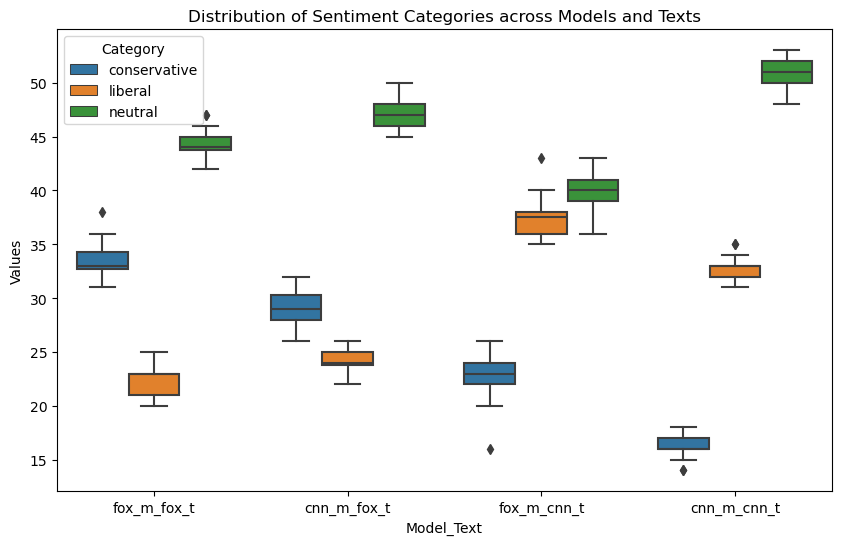

In [73]:
dfs = []
for model_text, categories in bootstrapped_results.items():
    for category, values in categories.items():
        df = pd.DataFrame({
            'Model_Text': model_text,
            'Category': category,
            'Values': values
        })
        dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

summary_stats = df.groupby(['Model_Text', 'Category']).agg(['mean', 'std', 'median'])
new_labels = ['fox_m_fox_t', 'cnn_m_fox_t', 'fox_m_cnn_t', 'cnn_m_cnn_t']


plt.figure(figsize=(10,6))
sns.boxplot(x='Model_Text', y='Values', hue='Category', data=df,order=new_order)
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
plt.title('Distribution of Sentiment Categories across Models and Texts')
plt.savefig("LLM_boxplot.png")
plt.show()

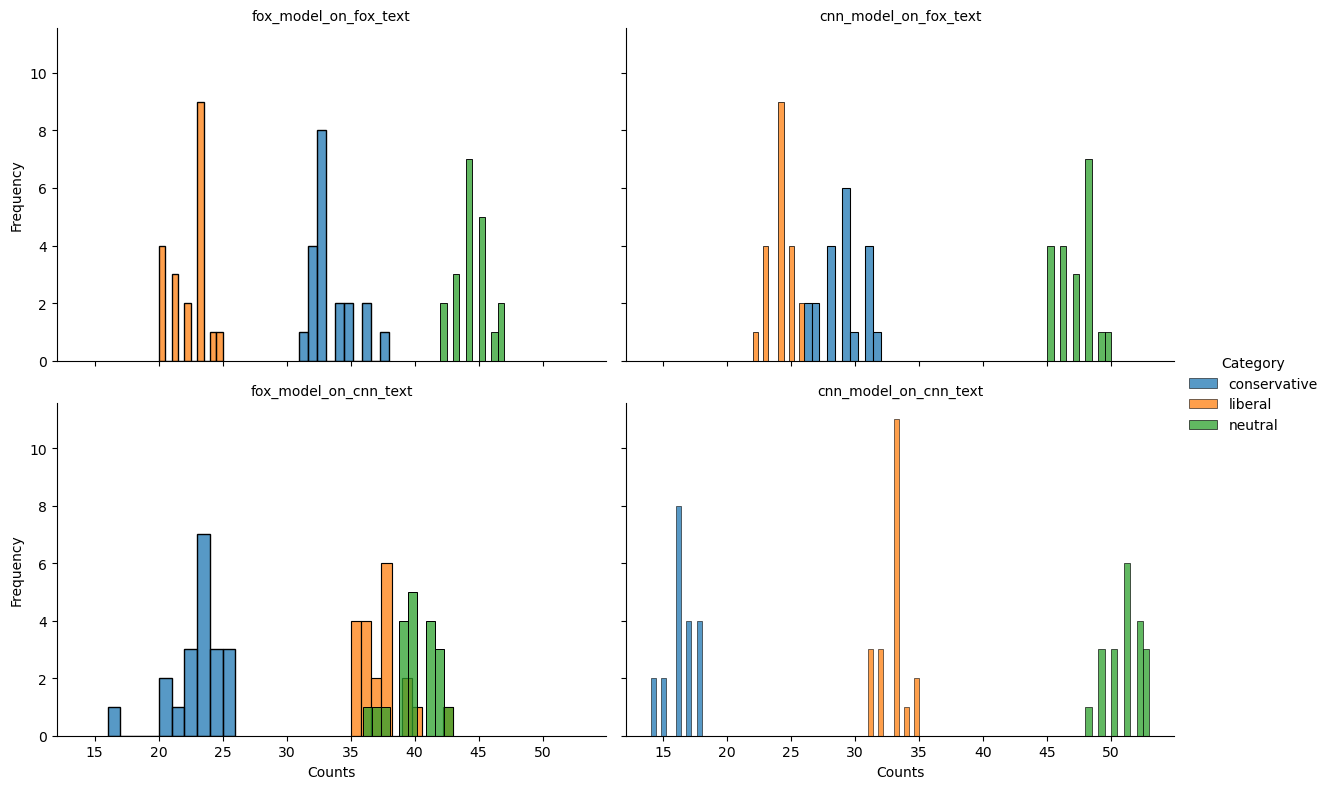

In [71]:
g = sns.FacetGrid(df, col="Model_Text", hue="Category", col_wrap=2, height=4, aspect=1.5,col_order=new_order)
g.map(sns.histplot, "Values", bins=10, kde=False)

g.add_legend()

g.set_titles("{col_name}")
g.set_axis_labels("Counts", "Frequency")
plt.show()
g.savefig("LLM_histogram_plot.png")

In [45]:
summary_stats = df.groupby(['Model_Text', 'Category']).agg(['mean', 'std', 'median'])

# Perform ANOVA to test for significant differences among categories within each model-text combination
anova_results = {}
for model_text in df['Model_Text'].unique():
    model_data = df[df['Model_Text'] == model_text]
    grouped_data = [model_data['Values'][model_data['Category'] == cat].values for cat in model_data['Category'].unique()]
    anova = stats.f_oneway(*grouped_data)
    anova_results[model_text] = anova

summary_stats, anova_results

(                                   Values                 
                                      mean       std median
 Model_Text            Category                            
 cnn_model_on_cnn_text conservative  16.30  1.218282   16.0
                       liberal       32.80  1.105013   33.0
                       neutral       50.90  1.447321   51.0
 cnn_model_on_fox_text conservative  28.90  1.713722   29.0
                       liberal       24.10  1.020836   24.0
                       neutral       47.00  1.450953   47.0
 fox_model_on_cnn_text conservative  22.65  2.254236   23.0
                       liberal       37.35  2.007224   37.5
                       neutral       40.00  1.747178   40.0
 fox_model_on_fox_text conservative  33.55  1.700619   33.0
                       liberal       22.15  1.460894   23.0
                       neutral       44.30  1.380313   44.0,
 {'fox_model_on_fox_text': F_onewayResult(statistic=1062.0163249810116, pvalue=7.772516045443824e-4

In [50]:
for text, model1, model2 in texts:
    print(text)
    print(model1, model2)

fox_text
fox_model_on_fox_text cnn_model_on_fox_text
cnn_text
fox_model_on_cnn_text cnn_model_on_cnn_text


In [48]:
results = {}
texts = [('fox_text', 'fox_model_on_fox_text', 'cnn_model_on_fox_text'), 
         ('cnn_text', 'fox_model_on_cnn_text', 'cnn_model_on_cnn_text')]

for text, model1, model2 in texts:
    results[text] = {}
    for category in ['conservative', 'liberal', 'neutral']:
        score1 = bootstrapped_results[model1][category]
        score2 = bootstrapped_results[model2][category]
        t_stat, p_value = ttest_ind(score1, score2)
        results[text][category] = {'t-statistic': t_stat, 'p-value': p_value}

results

{'fox_text': {'conservative': {'t-statistic': 8.613365644165484,
   'p-value': 1.8211601394015537e-10},
  'liberal': {'t-statistic': -4.893141472655047,
   'p-value': 1.8527077290697094e-05},
  'neutral': {'t-statistic': -6.029455258036293,
   'p-value': 5.186993910404674e-07}},
 'cnn_text': {'conservative': {'t-statistic': 11.082691555042409,
   'p-value': 1.8177796390351625e-13},
  'liberal': {'t-statistic': 8.88069066383166,
   'p-value': 8.303584445205464e-11},
  'neutral': {'t-statistic': -21.485668405480563,
   'p-value': 7.361741465836668e-23}}}

In [51]:
rows = []
for text, categories in results.items():
    for category, stats in categories.items():
        row = {
            'Text': text,
            'Category': category,
            'T-statistic': stats['t-statistic'],
            'P-value': stats['p-value']
        }
        rows.append(row)

results_df = pd.DataFrame(rows)
results_df

,Text,Category,T-statistic,P-value
0,fox_text,conservative,8.613366,1.821160e-10
1,fox_text,liberal,-4.893141,1.852708e-05
2,fox_text,neutral,-6.029455,5.186994e-07
3,cnn_text,conservative,11.082692,1.817780e-13
4,cnn_text,liberal,8.880691,8.303584e-11
5,cnn_text,neutral,-21.485668,7.361741e-23


In [52]:
results_df.to_csv('LLM_results_df.csv')